In [1]:
import os
import torch
import torchmetrics
import torch.nn.functional as F
import numpy as np
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import cv2
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
import random
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torchvision import datasets
import os
import shutil
from torchsummary import summary
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

%matplotlib inline

In [2]:
! pip install pytorch-lightning

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device} (GPU available: {torch.cuda.is_available()})")
print(f"GPU Name: {torch.cuda.get_device_name(0)}")


Using device: cuda (GPU available: True)
GPU Name: Tesla P100-PCIE-16GB


# Load Data

In [4]:
image_path="/kaggle/input/data-final/data/"

# Visualize Images

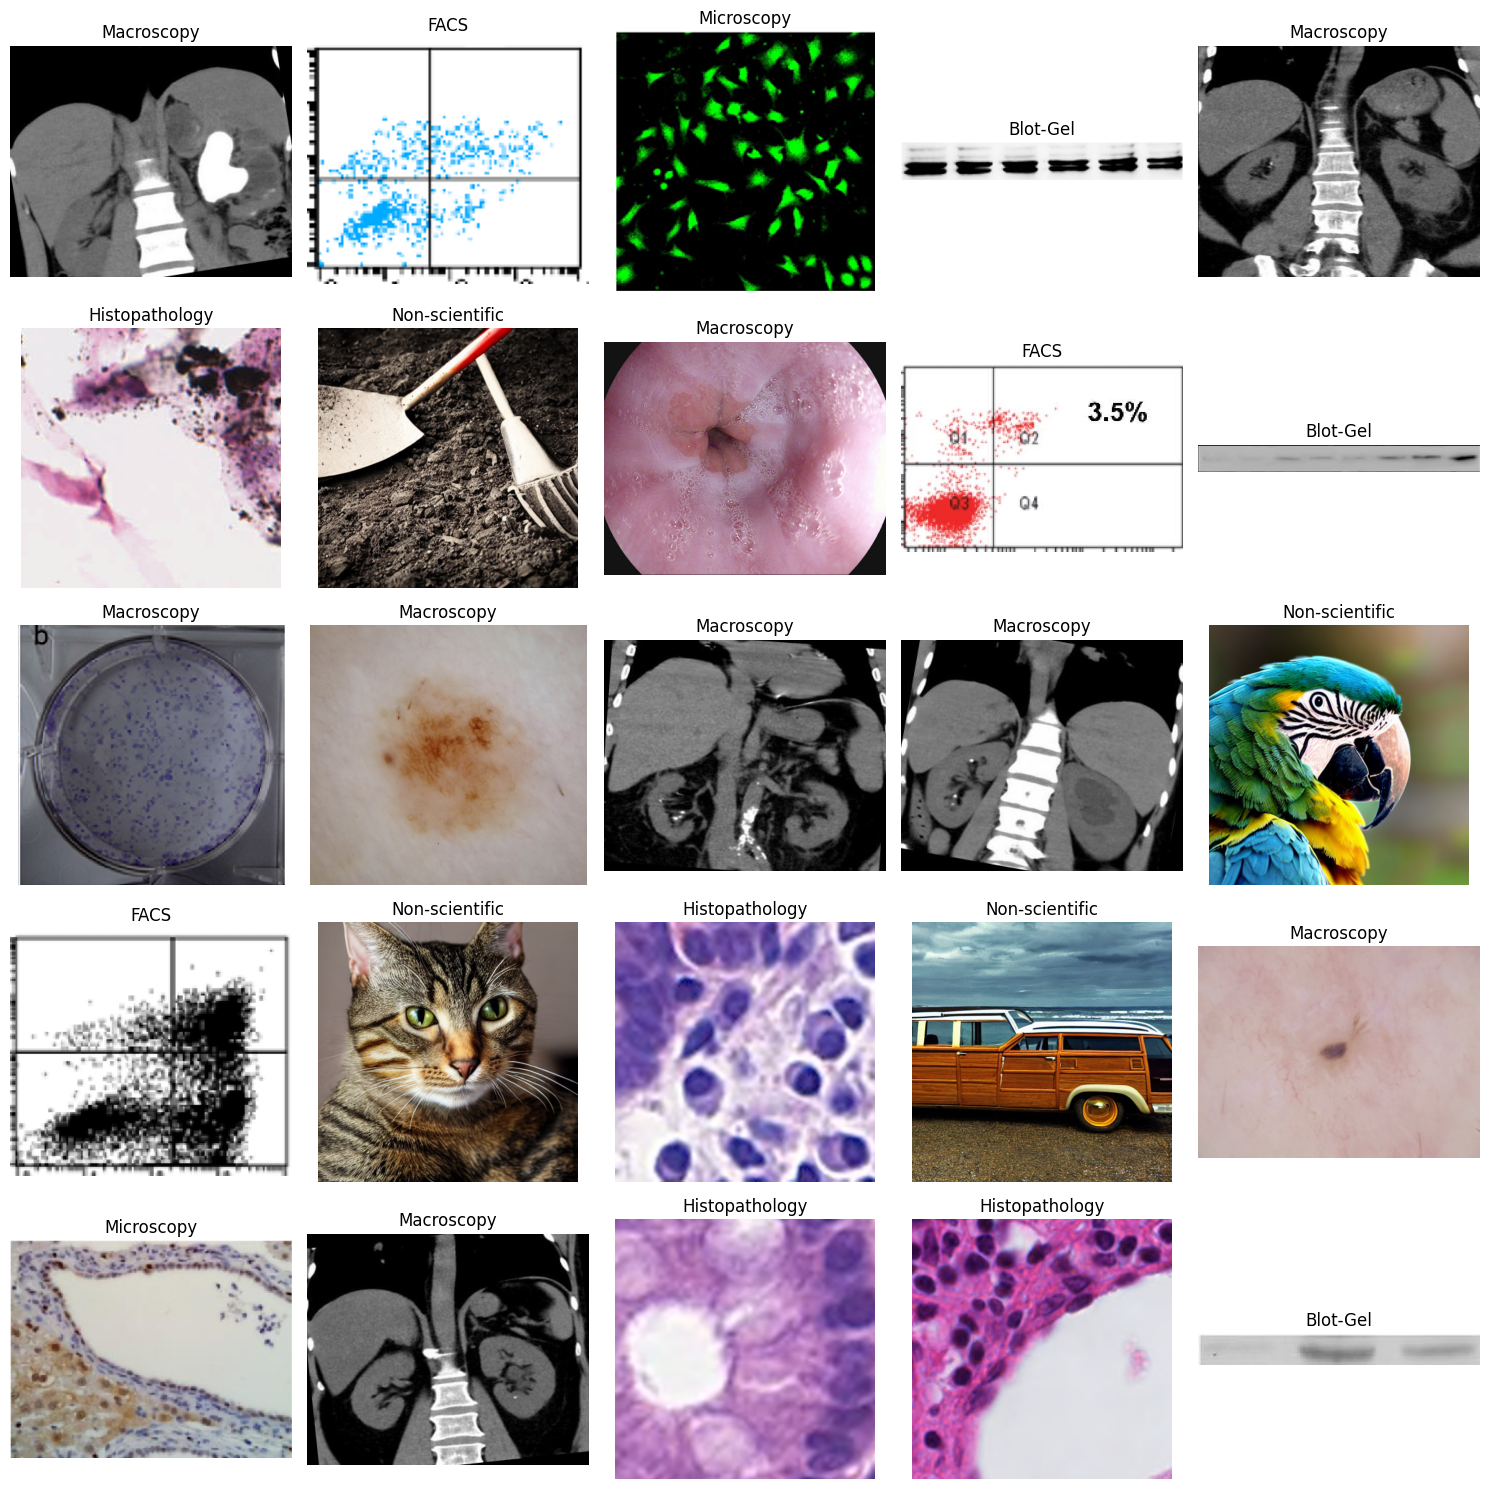

In [5]:

images= os.listdir(image_path)

# Initialize a figure for plotting the images
fig, axes = plt.subplots(5, 5, figsize=(15, 15))

# Flatten the axes for easy iteration
axes = axes.flatten()

# Select 25 random images from the dataset and plot them
for i in range(25):
  
    player = random.choice(images)
    
  
    player_images = os.listdir(os.path.join(image_path, player))

    img_file = random.choice(player_images)
    
    # Load the image
    img = Image.open(os.path.join(image_path, player, img_file))
    
    # Display the image in the grid
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axes for better clarity
    axes[i].set_title(player)  

# Adjust layout to make sure everything fits
plt.tight_layout()
plt.show()

# Compare Each Class Length

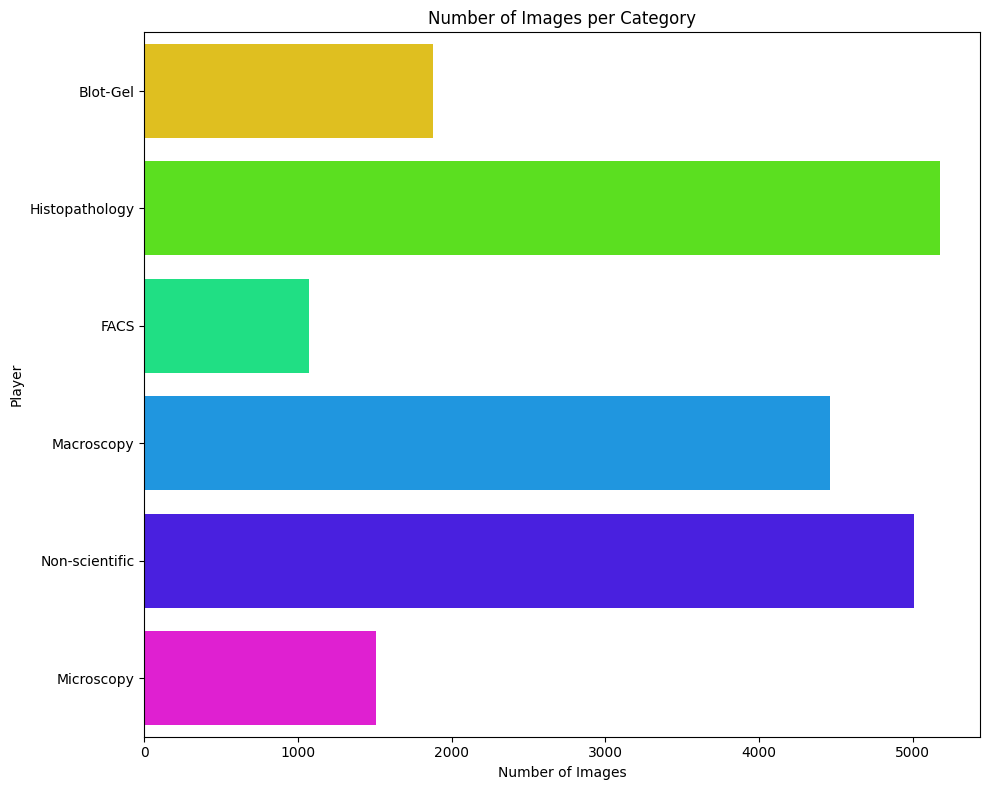

In [6]:

sc_image = os.listdir(image_path)


image_counts = [len(os.listdir(os.path.join(image_path, player))) for player in sc_image]

# Create a DataFrame for plotting
import pandas as pd
data = pd.DataFrame({'Player': sc_image,'Image Count': image_counts})

# Set up the seaborn plot
plt.figure(figsize=(10, 8))
sns.barplot(x='Image Count', y='Player', data=data, palette="hsv")

# Set plot labels and title
plt.xlabel('Number of Images')
plt.ylabel('Player')
plt.title('Number of Images per Category')

# Show the plot
plt.tight_layout()
plt.show()


# Find Label Name

In [7]:
label_names=os.listdir(image_path)
label_names=[label for label in label_names if os.path.isdir(os.path.join(image_path,label))]
print(f"Label Names : {label_names}")

Label Names : ['Blot-Gel', 'Histopathology', 'FACS', 'Macroscopy', 'Non-scientific', 'Microscopy']


# define the transformations

In [8]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize images to 150x150
    transforms.ToTensor(),  # Convert images to PyTorch tensors (scales the pixel values to [0, 1])
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize images to [0, 1]
])

# Load full dataset

In [9]:
full_dataset = datasets.ImageFolder(root=image_path, transform=transform)


In [10]:
# Get the class names and their corresponding labels
class_names = full_dataset.classes
class_to_idx = full_dataset.class_to_idx

# Print the mapping of class names to labels
print("Class to Label Mapping:")
for class_name, label in class_to_idx.items():
    print(f"Class: {class_name} -> Label: {label}")

Class to Label Mapping:
Class: Blot-Gel -> Label: 0
Class: FACS -> Label: 1
Class: Histopathology -> Label: 2
Class: Macroscopy -> Label: 3
Class: Microscopy -> Label: 4
Class: Non-scientific -> Label: 5


# Define the split ratios (e.g., 70% train, 15% validation, 15% test)

In [11]:
train_ratio=0.7
val_ratio=0.15
test_ratio=0.15
batch_size=16

# Calculate the sizes of each split

In [12]:
# Calculate the sizes of each split
total_size = len(full_dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size  # Ensure the sum matches total_size

# Split the dataset

In [13]:
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])


In [14]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
image, label = next(iter(train_loader))
print(f"Image Shape : {image.shape}")
print(f"Label Shape : {label.shape}")

Image Shape : torch.Size([16, 3, 150, 150])
Label Shape : torch.Size([16])


In [16]:
class_names = full_dataset.classes
print(f"Class names: {class_names}")

Class names: ['Blot-Gel', 'FACS', 'Histopathology', 'Macroscopy', 'Microscopy', 'Non-scientific']


# Create DataLoader

In [17]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Build Model

In [18]:


class LitModel(pl.LightningModule):
    def __init__(self, learning_rate=0.001, batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        self.batch_size = batch_size
        self.learning_rate = learning_rate

        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=6)
        self.valid_acc = torchmetrics.Accuracy(task="multiclass", num_classes=6)

        self.conv1 = nn.Sequential(nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2))
        self.conv2 = nn.Sequential(nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2))
        self.conv3 = nn.Sequential(nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2))
        self.fc1 = nn.Sequential(nn.Flatten(), nn.Linear(64 * 18 * 18, 256), nn.ReLU(), nn.Linear(256, 128), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(128, 6))

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

    def train_dataloader(self):
        return DataLoader(dataset=train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(dataset=val_dataset, batch_size=self.batch_size, shuffle=False)

    def training_step(self, batch, batch_idx):
        data, label = batch
        output = self(data)
        loss = nn.CrossEntropyLoss()(output, label)

        self.train_acc.update(output, label)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc_step', self.train_acc.compute(), on_step=True, on_epoch=False)

        return {'loss': loss}

    def on_train_epoch_end(self):
        self.log('train_acc_epoch', self.train_acc.compute(), on_epoch=True, prog_bar=True)
        self.train_acc.reset()

    def validation_step(self, batch, batch_idx):
        val_data, val_label = batch
        val_output = self(val_data)
        val_loss = nn.CrossEntropyLoss()(val_output, val_label)

        self.valid_acc.update(val_output, val_label)
        self.log('val_loss', val_loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('val_acc_step', self.valid_acc.compute(), on_step=True, on_epoch=False)

    def on_validation_epoch_end(self):
        self.log('val_acc_epoch', self.valid_acc.compute(), on_epoch=True, prog_bar=True)
        self.valid_acc.reset()

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Instantiate the model and move to device
model = LitModel(learning_rate=0.0001, batch_size=16).to(device)

# Print model summary with explicit device specification
summary(model, input_size=(3, 150, 150), batch_size=16, device=str(device))

Using device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 16, 150, 150]             448
              ReLU-2         [16, 16, 150, 150]               0
         MaxPool2d-3           [16, 16, 75, 75]               0
            Conv2d-4           [16, 32, 75, 75]           4,640
              ReLU-5           [16, 32, 75, 75]               0
         MaxPool2d-6           [16, 32, 37, 37]               0
            Conv2d-7           [16, 64, 37, 37]          18,496
              ReLU-8           [16, 64, 37, 37]               0
         MaxPool2d-9           [16, 64, 18, 18]               0
          Flatten-10                [16, 20736]               0
           Linear-11                  [16, 256]       5,308,672
             ReLU-12                  [16, 256]               0
           Linear-13                  [16, 128]          32,896
             ReLU-14

# Implement automatic learning rate tuner

In [19]:
# Set up TensorBoard logger
from pytorch_lightning.callbacks import TQDMProgressBar
from pytorch_lightning.callbacks import ModelCheckpoint, Callback 
from pytorch_lightning import Trainer
import torch.optim as optim
logger = TensorBoardLogger("tb_logs", name="my_model")
trainer=pl.Trainer(accelerator="gpu",max_epochs=5,logger=logger,devices=1,enable_progress_bar=True,callbacks=[TQDMProgressBar()])


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Finding best initial lr:   0%|          | 0/40 [00:00<?, ?it/s]

Suggested learning rate: 0.013335214321633235


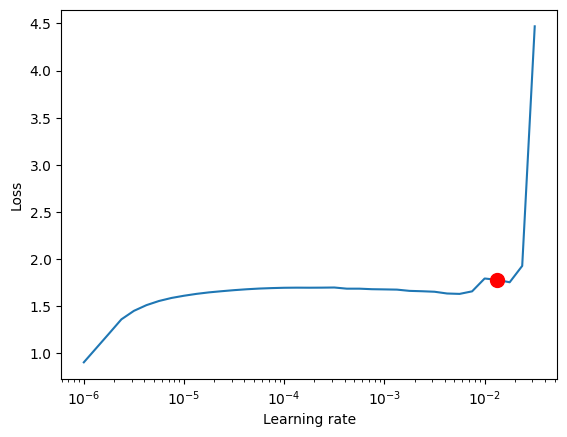

In [20]:
# Instantiate Tuner
tuner = pl.tuner.Tuner(trainer)


# Find optimal learning rate
lr_finder = tuner.lr_find(model,train_dataloaders=train_loader,val_dataloaders=val_loader,min_lr=1e-6,max_lr=0.1,
                          num_training=40,mode="exponential",
                          early_stop_threshold=4.0)

# Plot the results
fig = lr_finder.plot(suggest=True)
fig.show()

# Get the suggested learning rate
new_lr = lr_finder.suggestion()

# Update the model's learning rate
model.hparams.learning_rate = new_lr

print(f"Suggested learning rate: {new_lr}")

In [21]:
trainer=pl.Trainer(accelerator="gpu",max_epochs=5,logger=logger,devices=1,enable_progress_bar=True,callbacks=[TQDMProgressBar()])
trainer.fit(model)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [22]:
!ls /kaggle/working/tb_logs/my_model/version_7

checkpoints
events.out.tfevents.1741268219.dc5d4d38bbbc.573.0
events.out.tfevents.1741268226.dc5d4d38bbbc.573.1
hparams.yaml


In [23]:
# %load_ext tensorboard
# %tensorboard --logdir /kaggle/working/tb_logs/my_model/version_7

# **Using Callbacks-Early Stopping & Checkpointing**

In [24]:
# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',  # Monitor validation loss
    dirpath='models/',   # Save models in 'models/' directory
    filename='sample-catsvsdogs-{epoch:02d}-{val_loss:.2f}',  # Filename format
    save_top_k=3,        # Save the top 3 models based on monitored metric
    mode='min',          # Minimize val_loss
)

# Custom callback inheriting from Callback
class MyPrintingCallback(Callback):  # Updated to use Callback directly
    def on_init_start(self, trainer):
        print('Starting to init trainer!')

    def on_init_end(self, trainer):
        print('Trainer is initialized now')

    def on_train_end(self, trainer, pl_module):
        print('Do something when training ends')


# train with callbacks

In [25]:
trainer=pl.Trainer(accelerator="gpu",max_epochs=5,logger=logger,devices=1,enable_progress_bar=True,
                   callbacks=[checkpoint_callback, MyPrintingCallback(), TQDMProgressBar()])
trainer.fit(model)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /kaggle/working/models exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Do something when training ends


# Restore from checkpoints

In [26]:
checkpoint_callback.best_model_path

'/kaggle/working/models/sample-catsvsdogs-epoch=02-val_loss=1.09.ckpt'

# Load and run inference using the best checkpoint model

In [27]:
pretrained_model = LitModel.load_from_checkpoint(batch_size = 16, learning_rate=0.0001, checkpoint_path = checkpoint_callback.best_model_path)
pretrained_model = pretrained_model.to("cuda")
pretrained_model.eval()
pretrained_model.freeze()

#  Save our Model for Production Deployments

In [28]:
model = LitModel.load_from_checkpoint(batch_size = 32, learning_rate=0.001, checkpoint_path = checkpoint_callback.best_model_path)

script = model.to_torchscript()

# save for use in production environment
torch.jit.save(script, "model.pt")

# Run inference on 32 images from our test data loder

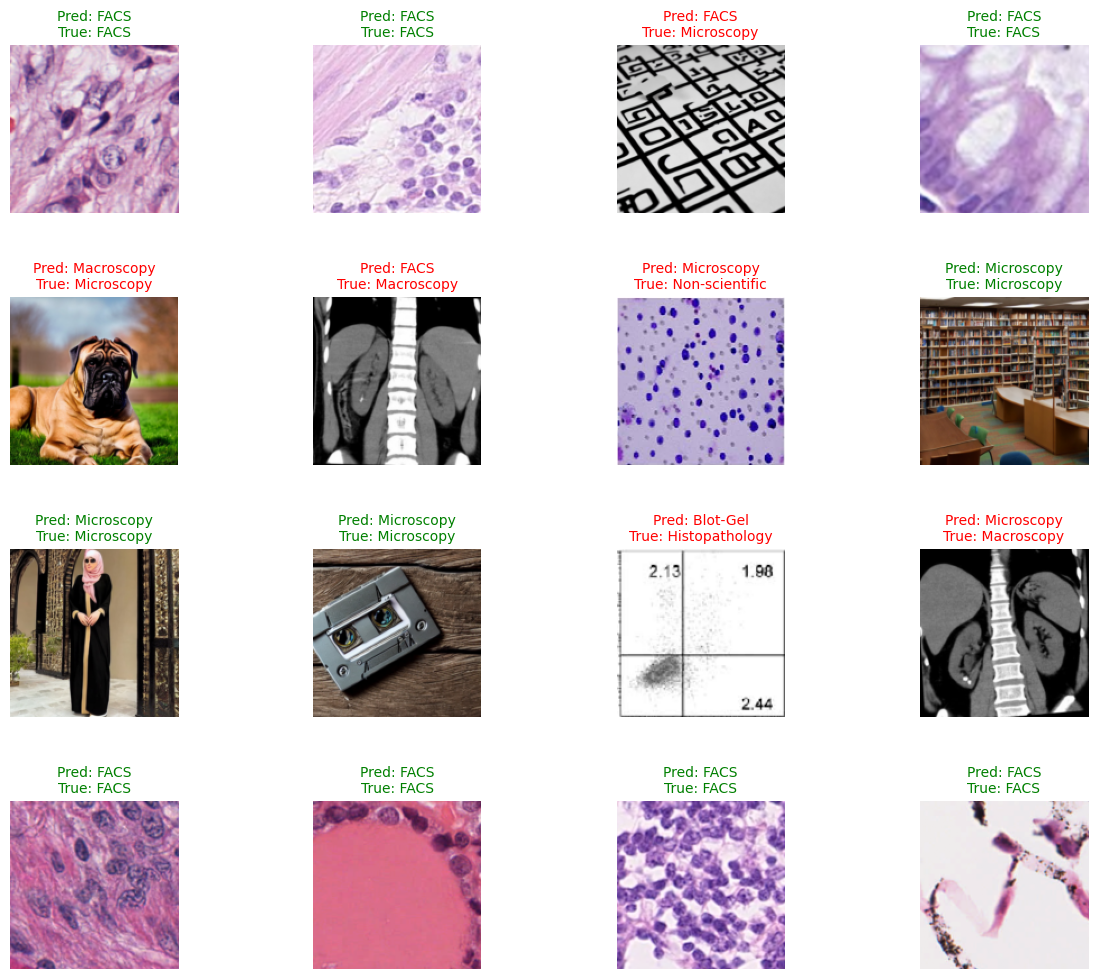

In [29]:

samples, labels = next(iter(test_loader))
samples, labels = samples.to(device), labels.to(device)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 12))  # 4x4 grid for 16 images
fig.subplots_adjust(hspace=0.5)

output = pretrained_model(samples)
pred = torch.argmax(output, dim=1).cpu().tolist()
labels = labels.cpu().tolist()

mean = torch.tensor([0.5, 0.5, 0.5]).view(3,1,1).to(device)  # Adjust if needed
std = torch.tensor([0.5, 0.5, 0.5]).view(3,1,1).to(device)

for num, (sample, ax) in enumerate(zip(samples, axes.flatten())):
    pred_label = label_names[pred[num]]
    true_label = label_names[labels[num]]

    title = f"Pred: {pred_label}\nTrue: {true_label}"
    color = "green" if pred[num] == labels[num] else "red"

    sample = sample * std + mean  # Reverse normalization
    sample = torch.clamp(sample, 0, 1)  # Ensure valid values

    sample = sample.cpu().numpy().transpose(1, 2, 0)  # Fix dimension for imshow
    
    ax.imshow(sample)
    ax.set_title(title, color=color, fontsize=10)
    ax.axis('off')

plt.show()


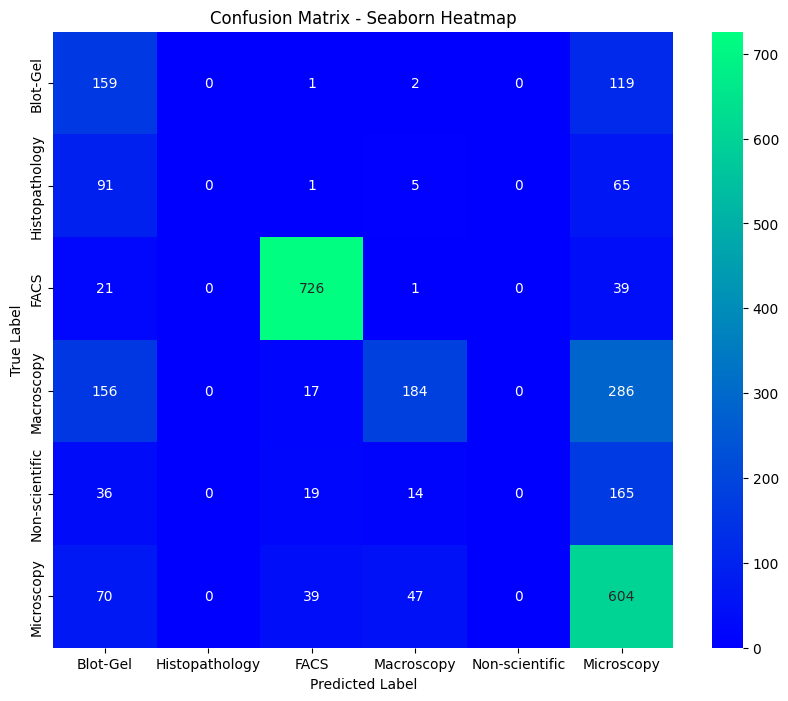

In [30]:

from sklearn.metrics import confusion_matrix,classification_report

# Assuming pretrained_model is your LitModel and test_loader is defined
pretrained_model.eval()  # Set to evaluation mode

# Collect all predictions and true labels
all_preds = []
all_trues = []

with torch.no_grad():  # No gradient computation for inference
    for samples, trule in test_loader:  # Iterate over entire test set
        samples = samples.to('cuda')  # Move images to GPU
        trule = trule.to('cuda')      # Move true labels to GPU
        
        output = pretrained_model(samples)  # Get model predictions
        pred = torch.argmax(output, dim=1)  # Predicted class indices
        
        all_preds.extend(pred.cpu().numpy())  # Append predictions
        all_trues.extend(trule.cpu().numpy()) # Append true labels

# Compute confusion matrix
cm = confusion_matrix(all_trues, all_preds)

# Plot using Seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="winter", xticklabels=label_names, yticklabels=label_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Seaborn Heatmap")
plt.show()


In [31]:
print(classification_report(all_trues,all_preds,target_names=label_names))

                precision    recall  f1-score   support

      Blot-Gel       0.30      0.57      0.39       281
Histopathology       0.00      0.00      0.00       162
          FACS       0.90      0.92      0.91       787
    Macroscopy       0.73      0.29      0.41       643
Non-scientific       0.00      0.00      0.00       234
    Microscopy       0.47      0.79      0.59       760

      accuracy                           0.58      2867
     macro avg       0.40      0.43      0.38      2867
  weighted avg       0.57      0.58      0.54      2867



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
